Dieser Quellcode ist Bestandteil der Dissertation von Ines Reinecke
vorgelegt am 11.07.2023 der Technischen Universität Dresden, Medizinische Fakultät

Dieser Code enthält 

* Einlesen des Datensatzes DS-Med und DS-Top1000
* Generierung einer neuen Spalte "ATC-Correct" in DS-Top1000
* Zusammenführen (Merge) der beiden Datensätze DS-Med und DS-Top1000 basierend auf der Spalte "MEDICATION" - nur für die unstrukturierten Medikationsverordnungen
* Generierung eines finalen Datensatzes von DS-Med, bei dem alle ATC Codes, die durch Algorithmus 3 zugeordnet werden in einer Spalte enthalten sind - nur für die Freitexte, die Teil von DS-Top1000 sind und manuell validiert wurden
* Generierung eines Datensatzes als Eingangsgröße für das Streudiagramm der Visualisierung - Strukturiertheit auf Basis von ATC Code

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_circles
import warnings
import os
from tqdm import tqdm
from scipy.stats import chisquare
import matplotlib.ticker as ticker
from matplotlib.ticker import FormatStrFormatter, StrMethodFormatter
warnings.filterwarnings('ignore')

In [28]:
# Farbpalette coolwarm, genutzt für alle Visualisierungen 
pal = sns.color_palette("coolwarm")
colorHex = pal.as_hex()
erste_farbe = colorHex[0]
zweite_farbe = colorHex[1]


In [29]:
# Einlesen von Datensatz DS-Top1000

df = pd.read_csv('../data_in/DS-TOP1000.csv',skipinitialspace=True, sep=";")

# Vorverarbeitung, Entfernen von Leerzeichen am Anfang und Ende von Freitexten in der Spalte "MEDICATION"
df['MEDICATION'] = df['MEDICATION'].str.replace('\n','\r')


In [30]:
#Feststellung des korrekten ATC Codes, es liegen ja unter Umständen unterschiedliche Ergebnisse der Algorithmen vor, und ggfs. erst korrigiert durch die manuelle Validierung

df['ATC_CORRECT'] = ""

for index, row in df.fillna(0).iterrows():
    if row['ATC_CODE']:
        corr = row['ATC_CODE']
    elif row['eval1']:
        corr = row['STEP1']
    elif row['eval2']:
        corr = row['STEP2']
    elif row['eval31']:
        corr = row['STEP31']
    elif row['eval32']:
        corr = row['STEP32']
    elif row['eval33']:
        corr = row['STEP33']
    elif row['correct']:
        corr = row['correct']
    else:
        # print('no correct value found: ', str(index), row['MEDICATION'])
        pass
    df.at[index, 'ATC_CORRECT'] = corr

In [31]:
#df[["TRUE12","TRUE13","TRUE23","TRUE123"]].describe(include='all')

print("Total Top1000 + size: ", (df["size"].sum()))

print("TRUE12 total: ",len(df.loc[((df['TRUE12'] == 1))]))
print("TRUE12 total + size: ", (df["size"].loc[((df['TRUE12'] == 1))]).sum())


print("TRUE12 + correct: ",len(df.loc[((df['TRUE12'] == 1) & (df['eval1'] == 1))]))

print("TRUE12 und nicht 3 total: ",len(df.loc[((df['TRUE12'] == 1)&(df['TRUE23'] != 1))]))

print("TRUE23 total: ",len(df.loc[((df['TRUE23'] == 1))]))
print("TRUE23 total + size: ", (df["size"].loc[((df['TRUE23'] == 1))]).sum())

print("TRUE23 und nicht 1 total: ",len(df.loc[((df['TRUE23'] == 1)&(df['TRUE13'] != 1))]))

print("TRUE23 + correct: ",len(df.loc[((df['TRUE23'] == 1) & (df['eval2'] == 1))]))
print("TRUE13 total: ",len(df.loc[((df['TRUE13'] == 1))]))
print("TRUE13 total + size: ", (df["size"].loc[((df['TRUE13'] == 1))]).sum())

print("TRUE13 und nicht 2 total: ",len(df.loc[((df['TRUE13'] == 1)&(df['TRUE23'] != 1))]))


print("nicht TRUE13 und nicht TRUE23: ",len(df.loc[((df['TRUE13'] != 1)&(df['TRUE23'] != 1))]))

print("TRUE13 + correct: ",len(df.loc[((df['TRUE13'] == 1) & (df['eval1'] == 1))]))
print("TRUE123 total: ",len(df.loc[((df['TRUE123'] == 1))]))
print("TRUE123 total + size: ", (df["size"].loc[((df['TRUE123'] == 1))]).sum())
print("TRUE123 + correct: ",len(df.loc[((df['TRUE123'] == 1) & (df['eval1'] == 1))]))

print("TOP1000-  correct STEP3: ", (len(df.loc[((df['eval31'] == 1))])))
print("TOP1000-  WRONG STEP3: ", (len(df.loc[((df['eval31'] == 0))])))
print("TOP1000-  correct STEP1: ", (len(df.loc[((df['eval1'] == 1))])))
print("TOP1000-  WRONG STEP1: ", (len(df.loc[((df['eval1'] == 0))])))
print("TOP1000-  correct STEP2: ", (len(df.loc[((df['eval2'] == 1))])))
print("TOP1000-  WRONG STEP2: ", (len(df.loc[((df['eval2'] == 0))])))
print("**********************************************")
print("TOP1000- total correct STEP3: ", (df["size"].loc[((df['eval31'] == 1))]).sum())


print("TOP1000- total WRONG STEP3: ", (df["size"].loc[((df['eval31'] == 0))]).sum())



Total Top1000 + size:  501183
TRUE12 total:  45
TRUE12 total + size:  57264
TRUE12 + correct:  45
TRUE12 und nicht 3 total:  0
TRUE23 total:  145
TRUE23 total + size:  96327
TRUE23 und nicht 1 total:  100
TRUE23 + correct:  140
TRUE13 total:  287
TRUE13 total + size:  209763
TRUE13 und nicht 2 total:  242
nicht TRUE13 und nicht TRUE23:  613
TRUE13 + correct:  286
TRUE123 total:  45
TRUE123 total + size:  57264
TRUE123 + correct:  45
TOP1000-  correct STEP3:  766
TOP1000-  WRONG STEP3:  234
TOP1000-  correct STEP1:  286
TOP1000-  WRONG STEP1:  1
TOP1000-  correct STEP2:  143
TOP1000-  WRONG STEP2:  5
**********************************************
TOP1000- total correct STEP3:  416585
TOP1000- total WRONG STEP3:  84598


In [32]:
# Check von Details der falsch erkannten Medikationsverordnungen durch die Algorithmen

wrongDF = df.loc[((df['eval31'] == 0) & (df['ATC_CORRECT'] != "nomed")& (df['ATC_CORRECT'] != "unspec")& (df['level'] != "3") & (df['level'] != "4"))]

groupedATC = wrongDF.groupby("ATC_CORRECT")["eval31"].value_counts()
groupedATC.reset_index(name='count')
grouped_ATC = groupedATC.rename('count').reset_index()

wrongDF['ATC_L1'] = wrongDF['ATC_CORRECT'].str[:1]
wrongDF['ATC_L2'] = wrongDF['ATC_CORRECT'].str[:3]
wrongDF['ATC_L3'] = wrongDF['ATC_CORRECT'].str[:4]
wrongDF['ATC_L4'] = wrongDF['ATC_CORRECT'].str[:5]
wrongDF[["MEDICATION","size","LEV1","ATC_CORRECT","ATC_L1","ATC_L2","ATC_L3","ATC_L4"]].describe(include='all')

,MEDICATION,size,LEV1,ATC_CORRECT,ATC_L1,ATC_L2,ATC_L3,ATC_L4
count,203,203.000000,203.000000,203,203,203,203,203
unique,203,NaN,NaN,91,14,37,56,71
top,E153,NaN,NaN,B05BB11,B,B05,B05B,B05BB
freq,1,NaN,NaN,14,64,40,36,33
mean,NaN,362.083744,67.261084,NaN,NaN,NaN,NaN,NaN
std,NaN,587.898041,15.091333,NaN,NaN,NaN,NaN,NaN
min,NaN,75.000000,29.000000,NaN,NaN,NaN,NaN,NaN
25%,NaN,107.500000,56.500000,NaN,NaN,NaN,NaN,NaN
50%,NaN,167.000000,64.000000,NaN,NaN,NaN,NaN,NaN
75%,NaN,318.000000,75.000000,NaN,NaN,NaN,NaN,NaN


In [33]:
# Einlesen Datensatz DS-Med
df_med_orders = pd.read_csv('../data_in/DS-Med-initial.csv', skipinitialspace=True, low_memory=False, lineterminator='\n').fillna(str())

# Vorverarbeitung DS-Med

# Ändern des Datentypes nach datetime
df_med_orders["START_DATE"] = pd.to_datetime(df_med_orders["START_DATE"])

# Eingrenzen auf die Jahre 2016 bis 2020
df_med_orders = df_med_orders[~((df_med_orders["START_DATE"].dt.year < 2016) | (df_med_orders["START_DATE"].dt.year > 2020))]

#Löschen von Zeilen, bei denen die Spalte "MEDICATION" leer ist
df_med_orders = df_med_orders[~df_med_orders['MEDICATION'].isnull()]

#Ändern des Datentypes von bestimmten Spalten im Dataframe
df_med_orders['MEDICATION'] = df_med_orders['MEDICATION'].astype(str)
df_med_orders['CAT_MATCH'] = df_med_orders['CAT_MATCH'].astype(str)

## Ändern der Einträge "Fuzzy Match" auf "No Match"
df_med_orders.loc[df_med_orders["CAT_MATCH"] == "Fuzzy Match", 'CAT_MATCH'] = "No Match"

#Löschen von Leerzeichen in der Spalte "MEDICATION"
df_med_orders['MEDICATION'] = df_med_orders['MEDICATION'].str.strip().replace("\n", '')


In [34]:
# neue Spalte "ATC_CORRECT" mit korrekten ATC Code

for atc in tqdm(np.unique(np.unique(df_med_orders[df_med_orders['CAT_MATCH'] == 'Match']['ATC_CODE']))):     
    df_med_orders.loc[(df_med_orders['ATC_CODE'] == atc) & (df_med_orders['CAT_MATCH'] == 'Match'), 'ATC_CORRECT'] = atc

100%|█████████████████████████████████████████| 707/707 [02:04<00:00,  5.70it/s]


In [35]:
#Einträge mit "nomed" markieren in Spalte ATC_CORRECT bei denen es sich nicht um Medikationsverordnungen handelt

df_med_orders.loc[df_med_orders['MEDICATION'].str.strip().str.startswith('BE '),'ATC_CORRECT'] = 'nomed'
df_med_orders.loc[df_med_orders['MEDICATION'].str.strip().str.startswith('BE:'),'ATC_CORRECT'] = 'nomed'
df_med_orders.loc[df_med_orders['MEDICATION'].str.strip().str.startswith('1 BE'),'ATC_CORRECT'] = 'nomed'
df_med_orders.loc[df_med_orders['MEDICATION'].str.strip().str.startswith('BB '),'ATC_CORRECT'] = 'nomed'
df_med_orders.loc[df_med_orders['MEDICATION'].str.strip().str.startswith('!'),'ATC_CORRECT'] = 'nomed'

In [36]:
# Ausgaben der unterschiedlichen Überseinstimmungen der Ergebnisse zwischen den drei Algorithmen
# jeweils immer pro eindeutigem Freitext Eintrag und multipliziert mit der Häufigkeit

print("****************************************************************************************************************")
print("TOP 1000 - Number of of different txt entries algorithm 1 + 2 results match: ", len(df.loc[df['TRUE12']==1].loc[df['STEP1']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 1 + 2 results match: ", df["size"].loc[df['TRUE12']==1].loc[df['STEP1']!=''].sum())
print("TOP 1000 - Number of of different txt entries algorithm 1 + 3 results match: ", len(df.loc[df['TRUE13']==1].loc[df['STEP1']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 1 + 3 results match: ", df["size"].loc[df['TRUE13']==1].loc[df['STEP1']!=''].sum())
print("TOP 1000 - Number of of different txt entries algorithm 2 + 3 results match: ", len(df.loc[df['TRUE23']==1].loc[df['STEP2']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 2 + 3 results match: ", df["size"].loc[df['TRUE23']==1].loc[df['STEP2']!=''].sum())
print("TOP 1000 - Number of of different txt entries algorithm 1 + 2 + 3 results match: ", len(df.loc[df['TRUE123']==1].loc[df['STEP2']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 1 + 2 + 3 results match: ", df["size"].loc[df['TRUE123']==1].loc[df['STEP2']!=''].sum())
print("****************************************************************************************************************")
print("TOP 1000 - Number of of different txt entries algorithm 1 identified an ATC code: ", len(df.loc[df['STEP1']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 1 identified an ATC code: ", df["size"].loc[df['STEP1']!=''].sum())
print("TOP 1000 - Number of of different txt entries algorithm 2 identified an ATC code: ", len(df.loc[df['STEP2']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 2 identified an ATC code: ", df["size"].loc[df['STEP2']!=''].sum())
print("TOP 1000 - Number of of different txt entries algorithm 3 identified an ATC code: ", len(df.loc[df['STEP31']!='']))
print("TOP 1000 - Total number of drug prescriptions algorithm 3 identified an ATC code: ", df["size"].loc[df['STEP31']!=''].sum())

****************************************************************************************************************
TOP 1000 - Number of of different txt entries algorithm 1 + 2 results match:  45
TOP 1000 - Total number of drug prescriptions algorithm 1 + 2 results match:  57264
TOP 1000 - Number of of different txt entries algorithm 1 + 3 results match:  287
TOP 1000 - Total number of drug prescriptions algorithm 1 + 3 results match:  209763
TOP 1000 - Number of of different txt entries algorithm 2 + 3 results match:  145
TOP 1000 - Total number of drug prescriptions algorithm 2 + 3 results match:  96327
TOP 1000 - Number of of different txt entries algorithm 1 + 2 + 3 results match:  45
TOP 1000 - Total number of drug prescriptions algorithm 1 + 2 + 3 results match:  57264
****************************************************************************************************************
TOP 1000 - Number of of different txt entries algorithm 1 identified an ATC code:  1000
TOP 1000 - Tota

In [37]:
#Generierung von zwei Dataframes, jeweils mit den strukturierten und unstrukturierten Einträgen

structured = df_med_orders.loc[df_med_orders['CAT_MATCH'] == "Match"]
unstructured = df_med_orders.loc[df_med_orders['CAT_MATCH'] == "No Match"]

In [38]:
# Zusammenführen und der beiden Dataframes: Originaldaten aus DS-Med unstrukturiert (dataframe "unstructured") und die Top1000 Freitexte mit dem korrekt zugeordneten ATC Code (dataframe df)

unstruct_merge_L = pd.merge(unstructured, df[['MEDICATION','ATC_CORRECT']],  how='left', on ='MEDICATION')

# Ausgabe der unterschiedlichen Gesamtzahlen

print("Expected size as calculated at the beginnung: ",df['size'].sum())
print("All medication orders: ", len(df_med_orders))
print("All sctructured: ", len(structured))
print("All unsctructured: ", len(unstructured))
print("left join: ", len(unstruct_merge_L))


# Löschen der neuen Spalte die durch das Zusammenführen generiert wurde
unstruct_merge_L = unstruct_merge_L.drop('ATC_CORRECT_x', 1)

# Umbenennen der neuen Spalte in die vorgesehene Benennung
unstruct_merge_L.rename(columns={"ATC_CORRECT_y": "ATC_CORRECT"}, inplace=True)



Expected size as calculated at the beginnung:  501183
All medication orders:  1768153
All sctructured:  843980
All unsctructured:  924173
left join:  924173


In [39]:
#Generierung des finalen Dataframes, bestehend aus den strukturierten und unstrukturierten Medikationsdaten, nachdem für die unstrukturierten die entsprechenden ATC Codes zugeordnet wurden

FINAL_med_orders = pd.concat([unstruct_merge_L, structured])

In [40]:
# auf dem finalen Dataframe werden nochmal die entsprechenden Medikationsverordnungen markitert, die gemäß der angewandten Regeln keine Medikationsverordnungen sind

FINAL_med_orders.loc[FINAL_med_orders['MEDICATION'].str.strip().str.startswith('BE '),'ATC_CORRECT'] = 'nomed'
FINAL_med_orders.loc[FINAL_med_orders['MEDICATION'].str.strip().str.startswith('BE:'),'ATC_CORRECT'] = 'nomed'
FINAL_med_orders.loc[FINAL_med_orders['MEDICATION'].str.strip().str.startswith('1 BE'),'ATC_CORRECT'] = 'nomed'
FINAL_med_orders.loc[FINAL_med_orders['MEDICATION'].str.strip().str.startswith('BB '),'ATC_CORRECT'] = 'nomed'
FINAL_med_orders.loc[FINAL_med_orders['MEDICATION'].str.strip().str.startswith('!'),'ATC_CORRECT'] = 'nomed'

In [41]:
# Änderung Datentyp von Spalten

df['eval1'] = df['eval1'].astype('Int64')
df['eval2'] = df['eval2'].astype('Int64')

# Ausgaben zu den durch die Algorithmen korrekt zugeordneten ATC für die Freitexte und die Medikationsverordnungen gesamt

print("correct number of results by algorithm 1: ", len(df.loc[df['eval1']==1]))
print("TOP 1000 - total drug prescription with correct ATC code by algorithm 1: ", df["size"].loc[df['eval1']==1].sum())
print("WRONG number of results by algorithm 1: ",len(df.loc[df['eval1']==0]))
print("TOP 1000 - total drug prescription with WRONG ATC code by algorithm 1: ", df["size"].loc[df['eval1']==0].sum())
print("correct number of results by algorithm 2: ", len(df.loc[df['eval2']==1]))
print("TOP 1000 - total drug prescription with correct ATC code by algorithm 1: ", df["size"].loc[df['eval2']==1].sum())
print("WRONG number of results by algorithm 2: ", len(df.loc[df['eval2']==0]))
print("TOP 1000 - total drug prescription with WRONG ATC code by algorithm 1: ", df["size"].loc[df['eval2']==0].sum())
print("correct number of results by algorithm 3 option 1: ", len(df.loc[df['eval31']==1]))
print("TOP 1000 - total drug prescription with correct ATC code by algorithm 1: ", df["size"].loc[df['eval31']==1].sum())
print("WRONG number of results by algorithm 3 option 1: ", len(df.loc[df['eval31']==0]))
print("TOP 1000 - total drug prescription with WRONG ATC code by algorithm 1: ", df["size"].loc[df['eval31']==0].sum())

correct number of results by algorithm 1:  286
TOP 1000 - total drug prescription with correct ATC code by algorithm 1:  209636
WRONG number of results by algorithm 1:  1
TOP 1000 - total drug prescription with WRONG ATC code by algorithm 1:  127
correct number of results by algorithm 2:  143
TOP 1000 - total drug prescription with correct ATC code by algorithm 1:  95037
WRONG number of results by algorithm 2:  5
TOP 1000 - total drug prescription with WRONG ATC code by algorithm 1:  1599
correct number of results by algorithm 3 option 1:  766
TOP 1000 - total drug prescription with correct ATC code by algorithm 1:  416585
WRONG number of results by algorithm 3 option 1:  234
TOP 1000 - total drug prescription with WRONG ATC code by algorithm 1:  84598


In [42]:
# Generieren neuer Spalten, die die ATC Codes auf den Level 1 bis 4 zusätzlich anzeigen

FINAL_med_orders['ATC_L1'] = FINAL_med_orders['ATC_CORRECT'].str[:1]
FINAL_med_orders['ATC_L2'] = FINAL_med_orders['ATC_CORRECT'].str[:3]
FINAL_med_orders['ATC_L3'] = FINAL_med_orders['ATC_CORRECT'].str[:4]
FINAL_med_orders['ATC_L4'] = FINAL_med_orders['ATC_CORRECT'].str[:5]

# Spalte ATC_L1 benötigt für die Visualisierung auch noch die nomed, unspec und no_eval Einträge

FINAL_med_orders.loc[ (FINAL_med_orders['ATC_CORRECT'] == "nomed"),"ATC_L1"] = 'nomed'
FINAL_med_orders.loc[ (FINAL_med_orders['ATC_CORRECT'] == "unspec"),"ATC_L1"] = 'unspec'
FINAL_med_orders['ATC_CORRECT'] = FINAL_med_orders['ATC_CORRECT'].fillna('no_eval')
FINAL_med_orders.loc[ (FINAL_med_orders['ATC_CORRECT'] == "no_eval"),"ATC_L1"] = 'no_eval'

# Neue Spalte mit den Informationen ob eine Medikationsverordnung strukturiert oder unstrukturiert vorliegt, als boolean (0 und 1)

FINAL_med_orders.loc[ (FINAL_med_orders['CAT_MATCH'] == "No Match"),"CAT_MATCH_INT"] = 0
FINAL_med_orders.loc[ (FINAL_med_orders['CAT_MATCH'] == "Match"),"CAT_MATCH_INT"] = 1

In [43]:
# Generieren eines Dataframes welches zwei Spalten enthält, die ATC Codes und die Häufigkeit der Nutzung laut den Medikationsverordnungen aus DS-Med

improved_medication_orders_atc = FINAL_med_orders.groupby("ATC_CORRECT").size().reset_index(name='count').sort_values('count', ascending=False)

In [44]:
# Dataframe generieren, gruppierte Einträge auf Basis von L1

groupedATC = FINAL_med_orders.groupby("ATC_L1")["CAT_MATCH_INT"].value_counts()

#groupedATC_L2 = FINAL_med_orders.groupby(["ATC_L1","ATC_L2"])["CAT_MATCH_INT"].value_counts()

groupedATC.reset_index(name='count')
grouped_ATC = groupedATC.rename('count').reset_index()
print(grouped_ATC)


     ATC_L1  CAT_MATCH_INT   count
0         A            1.0  137988
1         A            0.0  109392
2         B            1.0  164032
3         B            0.0   85248
4         C            1.0  170703
5         C            0.0   76605
6         D            1.0    2127
7         D            0.0    1407
8         G            0.0    5116
9         G            1.0    3662
10        H            1.0   51296
11        H            0.0   11981
12        J            1.0   60844
13        J            0.0   27815
14        L            1.0    8670
15        L            0.0    4788
16        M            0.0   24736
17        M            1.0   12083
18        N            1.0  197831
19        N            0.0  123881
20        P            0.0    1119
21        P            1.0     342
22        R            1.0   19686
23        R            0.0    7751
24        S            1.0    5077
25        S            0.0     102
26        V            1.0    9639
27        V         

In [45]:
#Streudiagramm Daten Vorbereitung - für Visualisierung und Transparenz der Strukturiertheit pro ATC Code
groupedATC_L5 = FINAL_med_orders.groupby("ATC_CORRECT")["CAT_MATCH_INT"].value_counts()
groupedATC_L5.reset_index(name='count')
groupedATC_L5 = groupedATC_L5.rename('count').reset_index()
spreadATC5=groupedATC_L5.pivot_table(index=['ATC_CORRECT'],columns='CAT_MATCH_INT',values='count',fill_value=0)

spreadATC5 = spreadATC5.reset_index()
spreadATC5.columns = ['ATC_CORRECT', 'unstructured', 'structured']
spreadATC5['total']=(spreadATC5['unstructured'] + spreadATC5['structured'])
spreadATC5['percent structured'] = ((spreadATC5['structured'] / spreadATC5['total']) *100).round(2)
spreadATC5['percent unstructured'] = ((spreadATC5['unstructured'] / spreadATC5['total']) *100).round(2)
spreadATC5 = spreadATC5.sort_values(by=['total'])
#export multimedia appendix 3 data
spreadATC5.to_csv('../data_results/01_data_structure_results/scatter_input.csv', index=False)

In [46]:
#Data prep for barplot, stacked, Level 1 only
spreadATC=grouped_ATC.pivot_table(index=['ATC_L1'],columns='CAT_MATCH_INT',values='count',fill_value=0)
spreadATC = spreadATC.reset_index()
spreadATC.columns = ['ATC_L1', 'unstructured', 'structured']
spreadATC['total']=(spreadATC['unstructured'] + spreadATC['structured'])
spreadATC['Perc_Struct'] = ((spreadATC['structured'] / spreadATC['total']) *100).round(2)
spreadATC['Perc_UnStruct'] = ((spreadATC['unstructured'] / spreadATC['total']) *100).round(2)
spreadATC = spreadATC.sort_values(by=['Perc_Struct'])
#print(spreadATC5)
print(spreadATC5["total"].loc[spreadATC5["total"]> 45000].sum()/spreadATC5["total"].sum())
print(spreadATC5.loc[spreadATC5["total"]> 45000])

0.39500031954248305
    ATC_CORRECT  unstructured  structured   total  percent structured  \
493     N02AA05          1482       44952   46434               96.81   
14      A02BC02         55278       10490   65768               15.95   
143     B05BB01         21781       46345   68126               68.03   
505     N02BB02         35470       44905   80375               55.87   
738       nomed        166307           0  166307                0.00   
737     no_eval        271411           0  271411                0.00   

     percent unstructured  
493                  3.19  
14                  84.05  
143                 31.97  
505                 44.13  
738                100.00  
737                100.00  


In [47]:
spreadATC5_new = spreadATC5[~(spreadATC5['ATC_CORRECT']=='nomed')]
spreadATC5_new = spreadATC5_new[~(spreadATC5_new['ATC_CORRECT']=='unspec')]
spreadATC5_new = spreadATC5_new[~(spreadATC5_new['ATC_CORRECT']=='no_eval')]

spreadATC5_new = spreadATC5_new.sort_values('total', ascending=False)

#Anhang mit allen ATC Codes und dem Grad der Strukturiertheit
spreadATC5_new.to_csv('../data_results/01_data_structure_results/atc_codes_alle_739.csv', index=False)

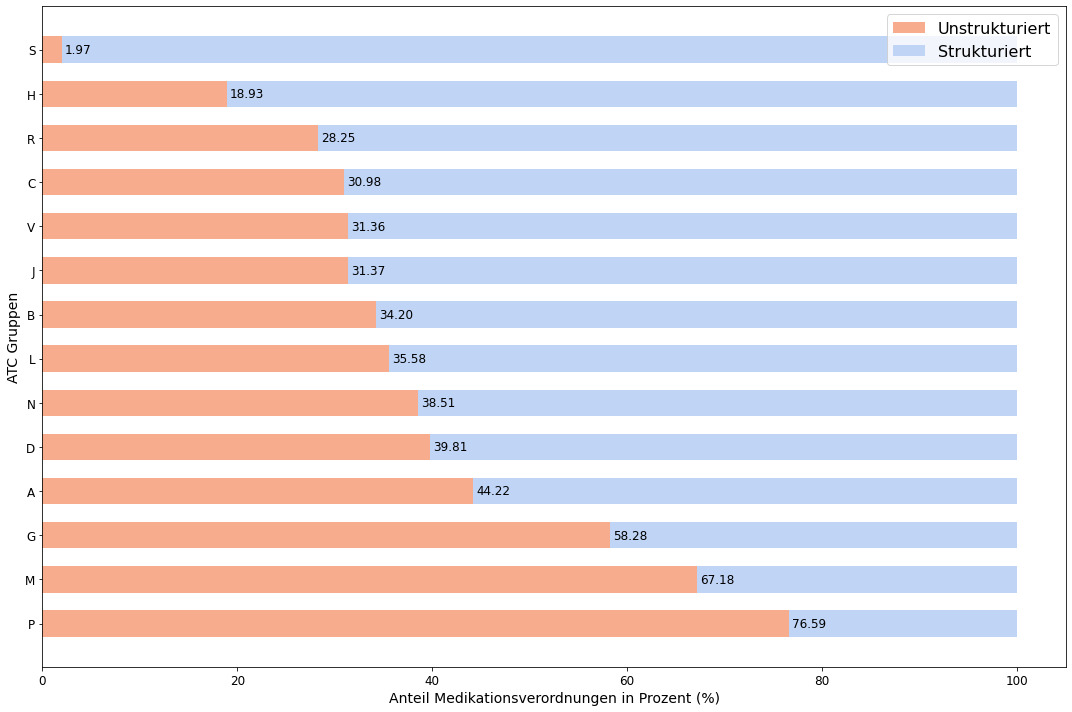

In [48]:


spreadATC = spreadATC[~(spreadATC['ATC_L1']=='nomed')]
spreadATC = spreadATC[~(spreadATC['ATC_L1']=='unspec')]
spreadATC = spreadATC[~(spreadATC['ATC_L1']=='no_eval')]

fig, ax = plt.subplots(figsize=[15, 10])
plt.rcParams["figure.autolayout"] = True

# Farbpalette coolwarm generieren und Farben tauschen
cmap = plt.cm.coolwarm
colors = cmap([0.7, 0.4])  # Farben tauschen: 80% und 20% der coolwarm-Palette

ax.barh(spreadATC['ATC_L1'], spreadATC['Perc_UnStruct'], align='center', height=0.6, color=colors[0], label='Unstrukturiert')
ax.barh(spreadATC['ATC_L1'], spreadATC['Perc_Struct'], align='center', height=0.6, left=spreadATC['Perc_UnStruct'], color=colors[1], label='Strukturiert')
ax.set_yticks(spreadATC['ATC_L1'])
ax.set_ylabel('ATC Gruppen', fontsize=14)
ax.set_xlabel('Anteil Medikationsverordnungen in Prozent (%)', fontsize=14)

ax.bar_label(ax.containers[0], fmt='%.2f',
             label_type='edge', 
             color='black', 
             fontsize=12, 
             padding=3)

ax.tick_params(axis='both', labelsize=12)
ax.legend(fontsize=16)
plt.tight_layout()
plt.savefig('../data_results/01_data_structure_results/finalAssessmentATCL1.png', dpi=400, bbox_inches='tight')
